In [1]:
import os
import numpy as np
import pandas as pd
# from typing import Tuple
from matplotlib import pyplot as plt
from skimage import (filters)
from tqdm import tqdm
from pyimzml.ImzMLParser import ImzMLParser, getionimage

In [2]:
# Define folder that contains the dhg dataset and files
DHG_PATH = "C:/Users/Leor/Desktop/Thesis/DHG"
# Define folder that contains the preprocessed dhg dataset
DHG_IN_PATH = f"{DHG_PATH}/Preprocessed"
# Define file that contains dhg clinical state annotations
CLINICAL_STATE_ANNOTATIONS_PATH = f"{DHG_PATH}/Clinical_state_annotations.csv"
# Mz value to get in order to threshold for tissue
TRESH_MZ = 750
# Mz tolerance value to get in order to threshold for tissue
TRESH_MZ_TOL = 150
# Treshould standard deviation for Gaussian kernel
TRESH_GAUSSIAN_SIGMA = 0.5

In [3]:
# Read clinical state annotations csv
clinical_state_df = pd.read_csv(CLINICAL_STATE_ANNOTATIONS_PATH, index_col=0)

In [4]:
# Create dict's to store each MSI info
mean_spectras = {}
# Define object to store common mz values
mzs = None

# Loop over each MSI
for index, _ in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Define object to store MSI tissue spectra's sum and count
  sum_spectra = 0
  count_spectra = 0

  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH, f"{index}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Get mzs ans spectra
        mzs, intensities = reader.getspectrum(idx)
        # Add spectra's
        sum_spectra += intensities
        count_spectra += 1
  
    # Store mean for msi spectra's
    mean_spectras[index] = sum_spectra / count_spectra

MSI Loop: 100%|██████████| 48/48 [05:09<00:00,  6.44s/it]


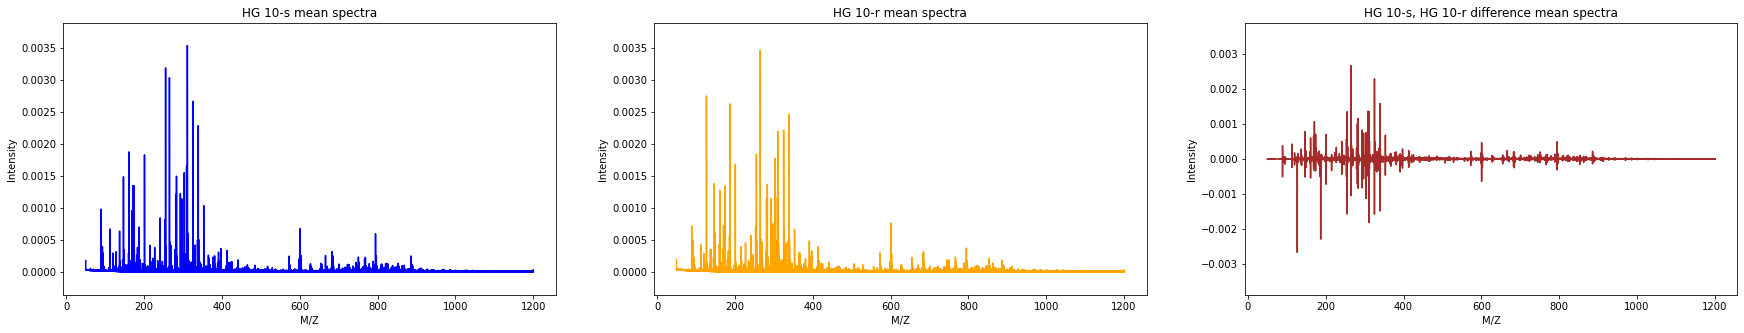

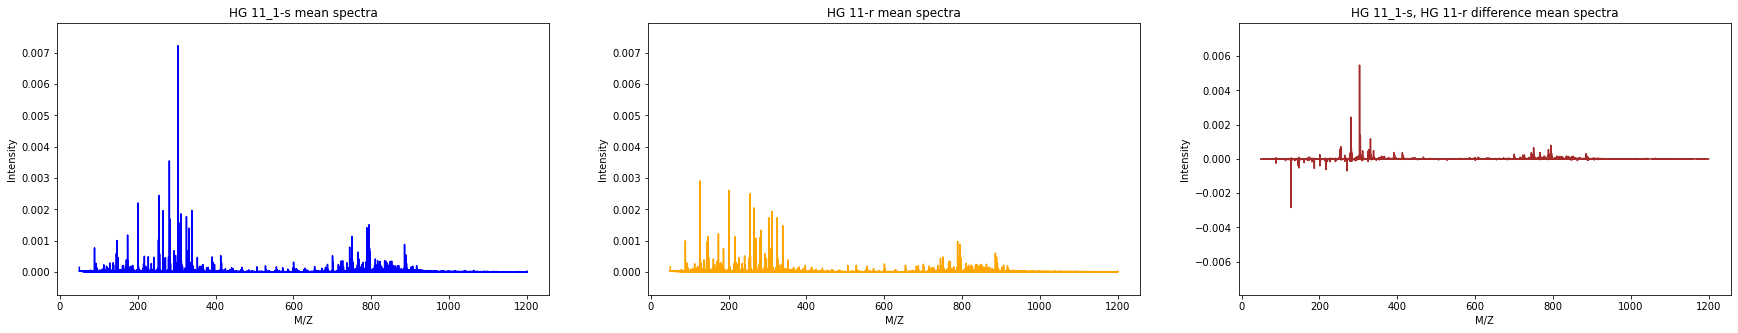

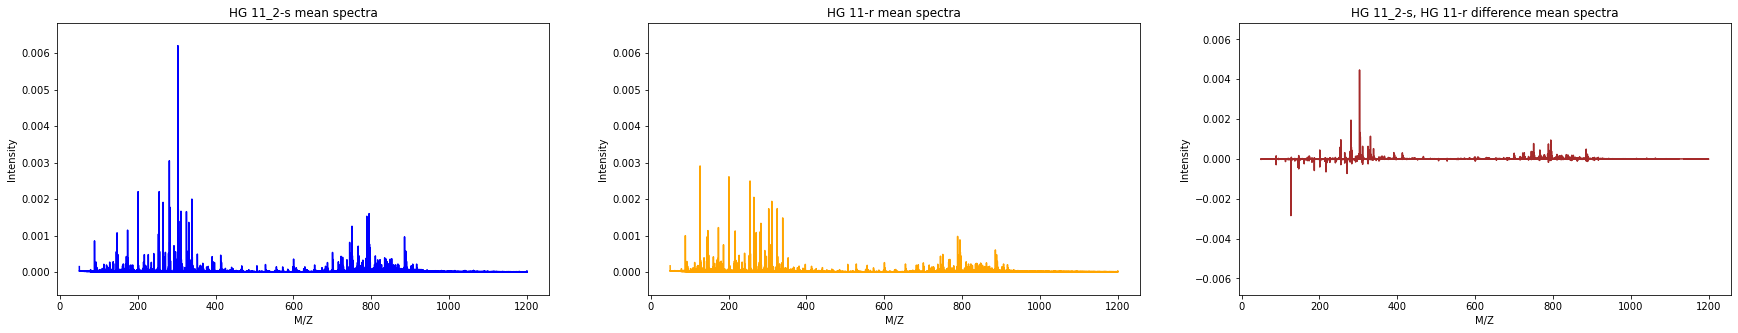

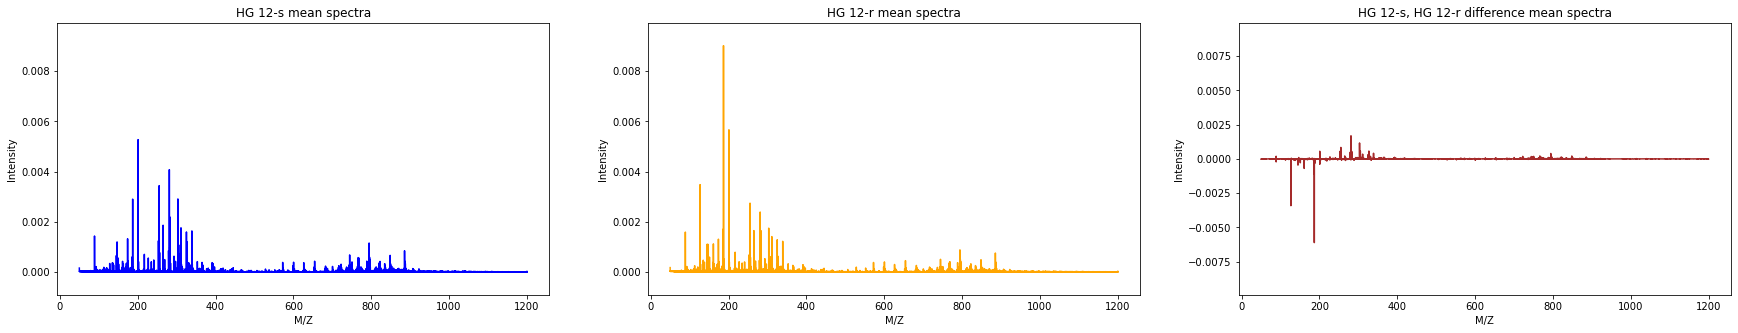

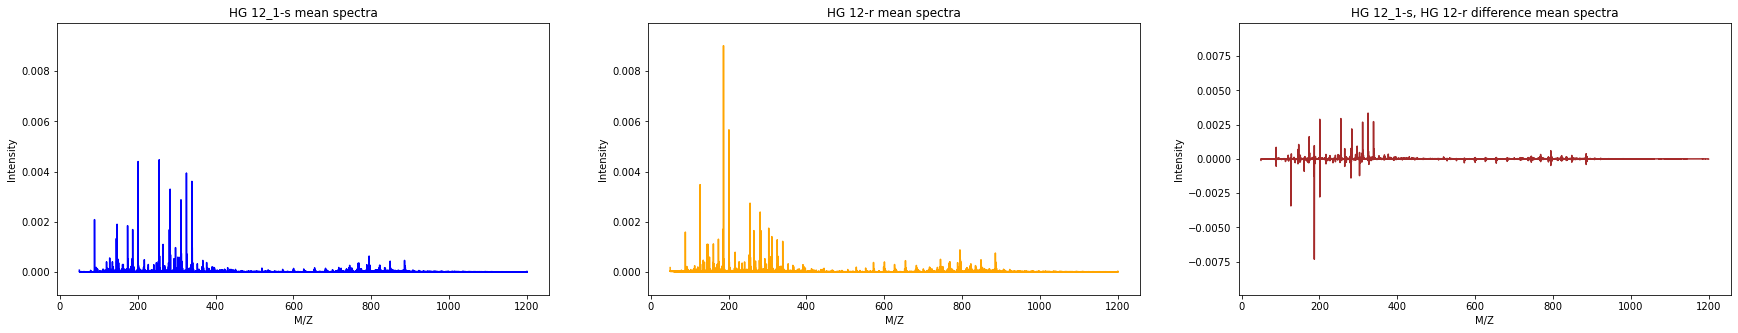

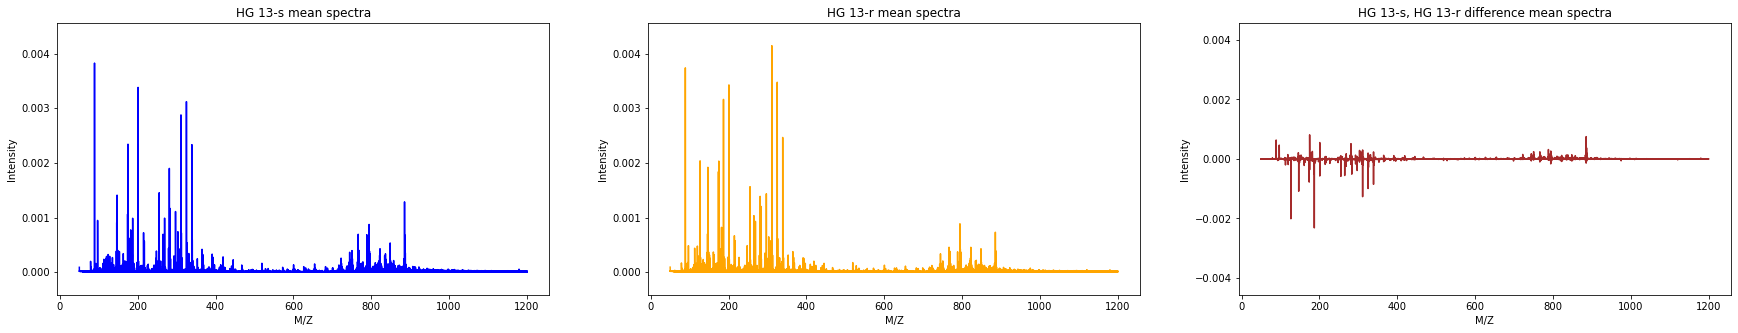

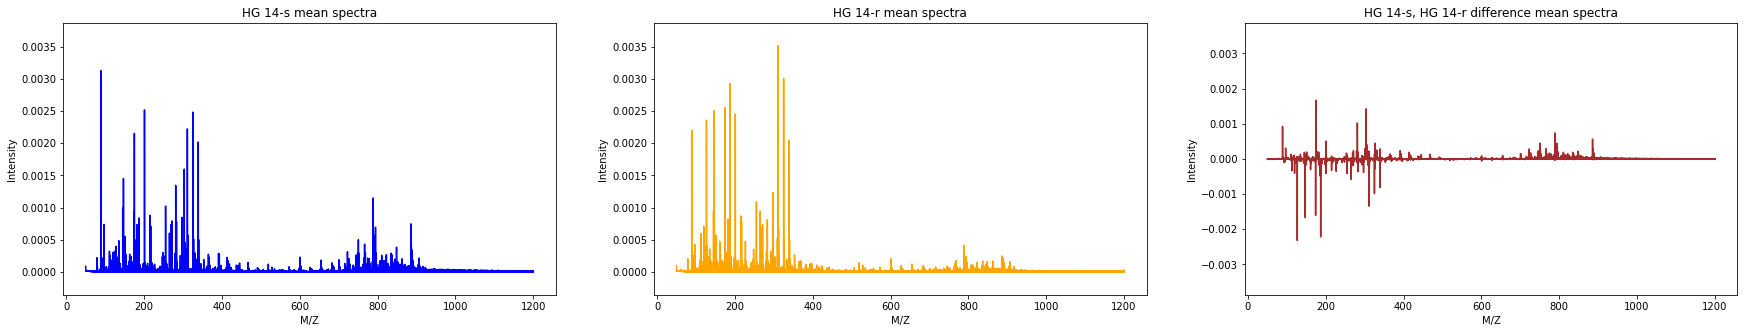

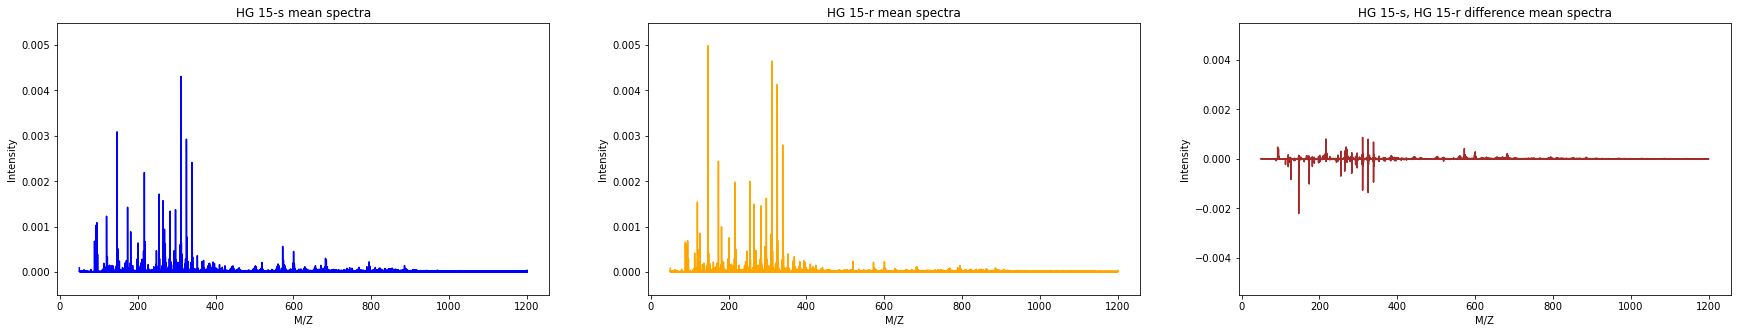

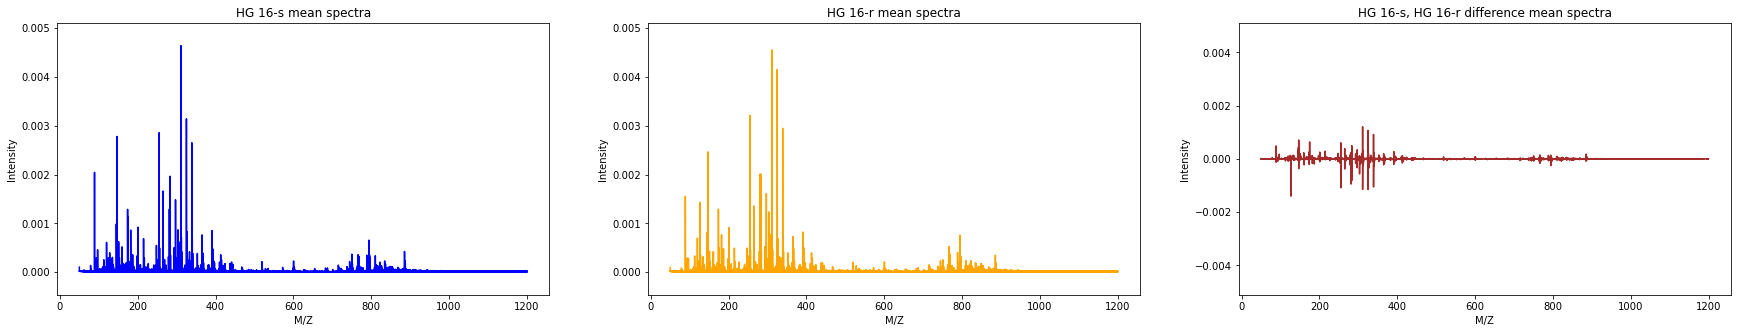

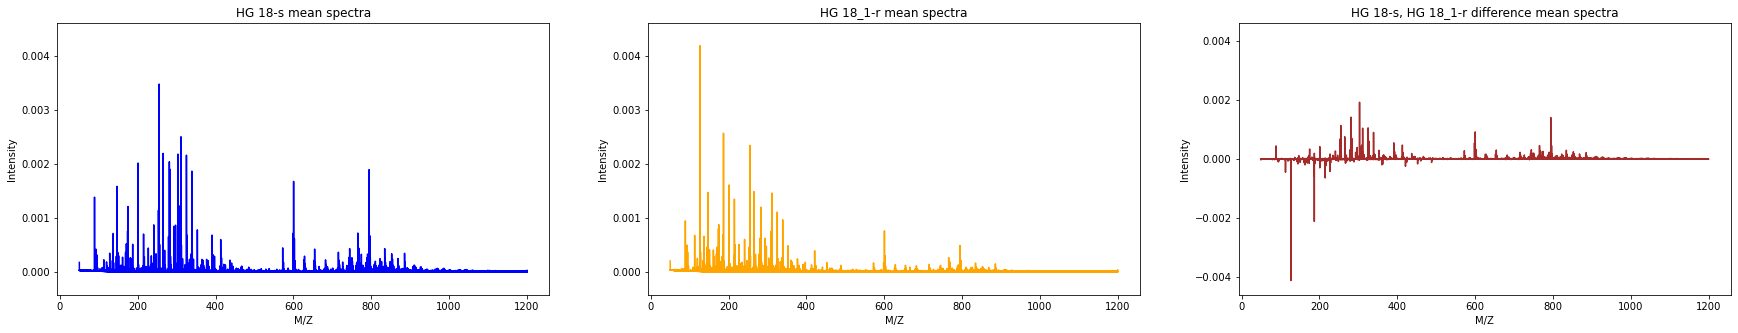

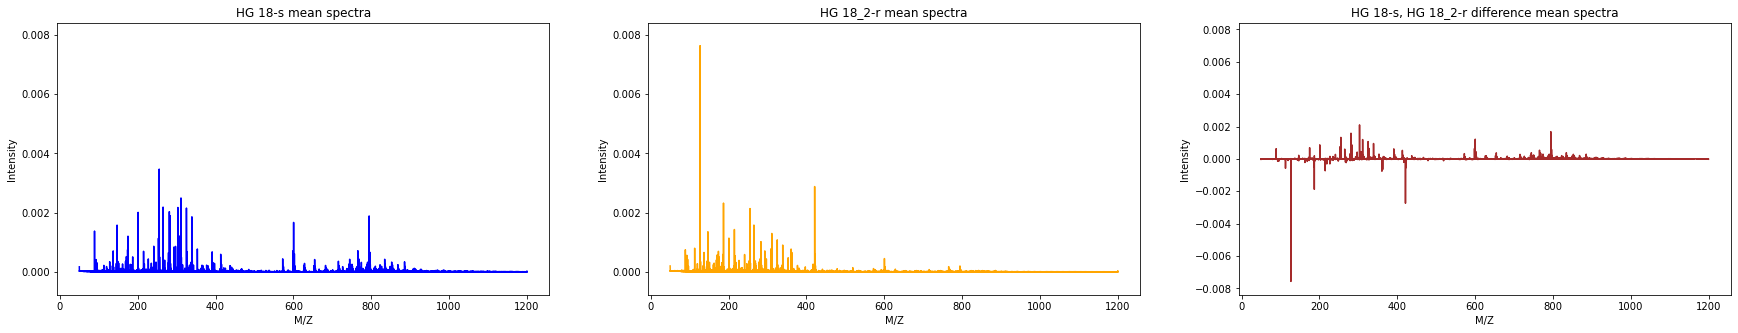

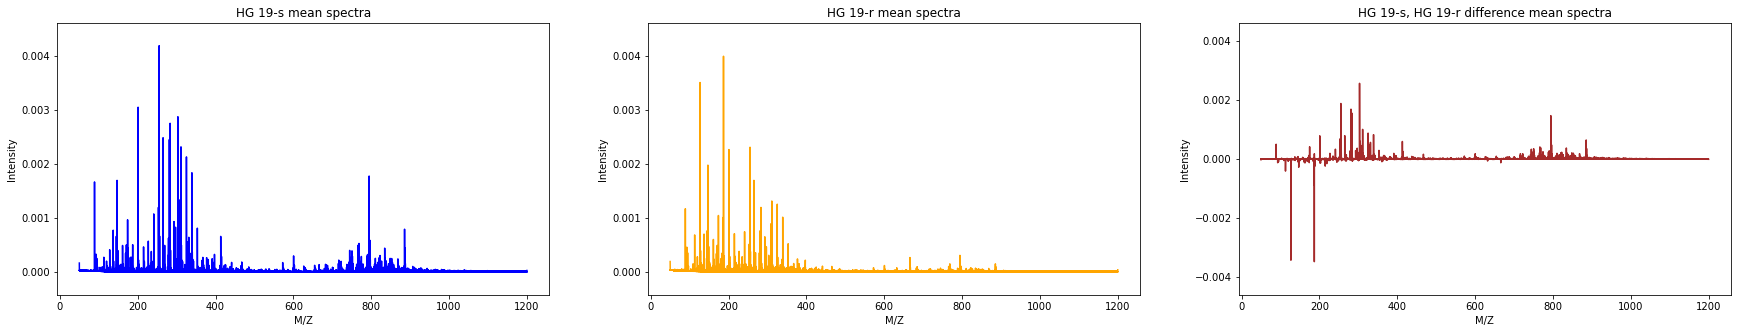

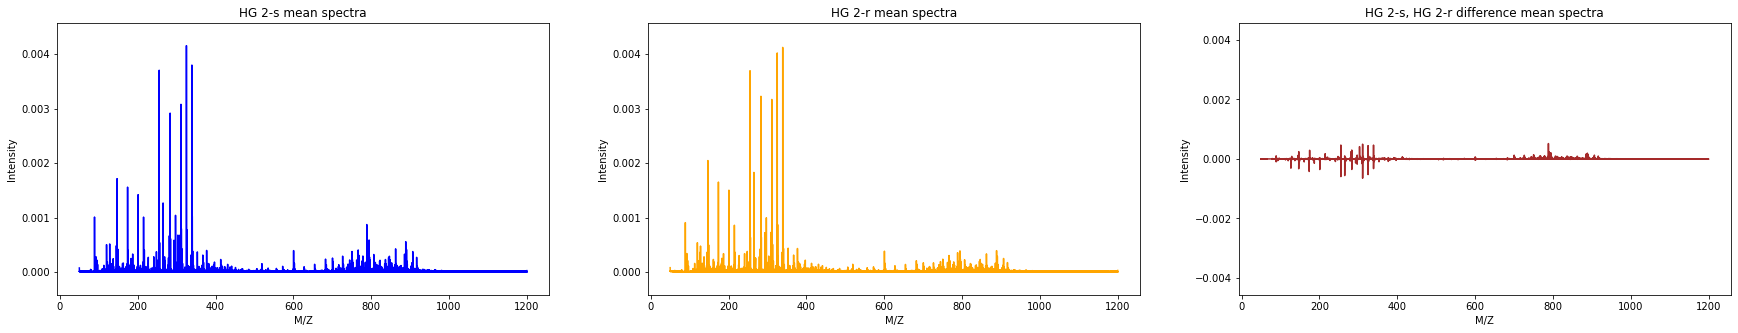

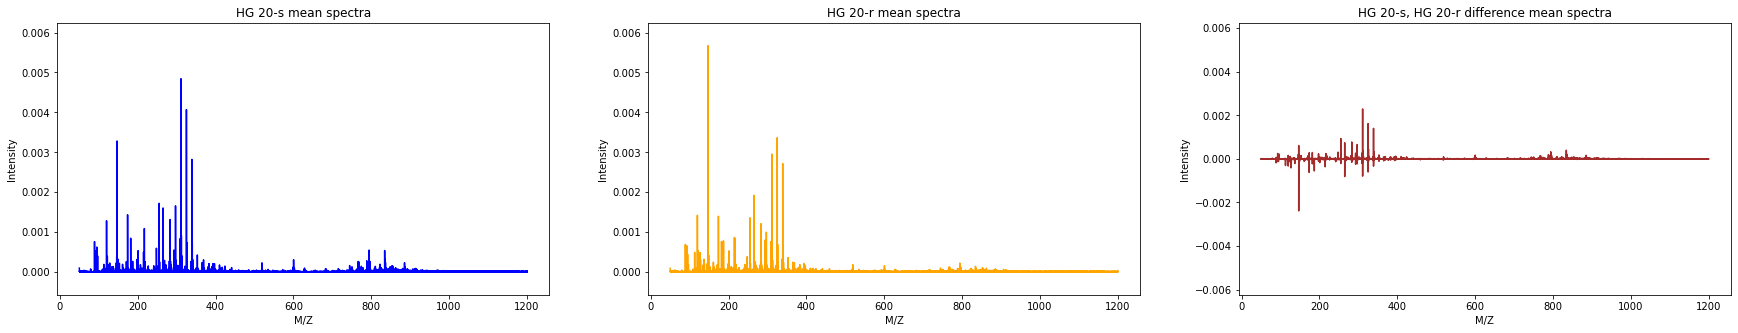

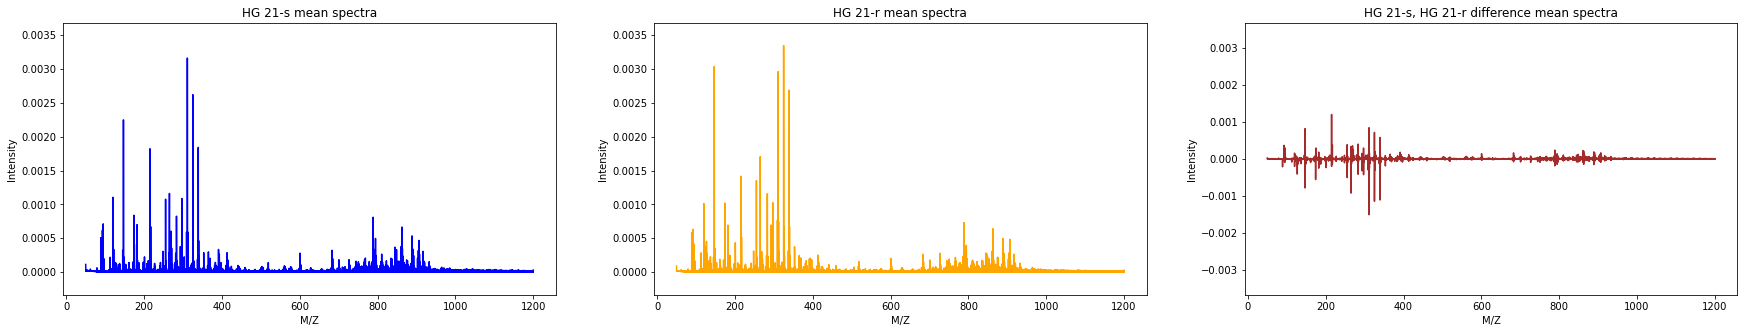

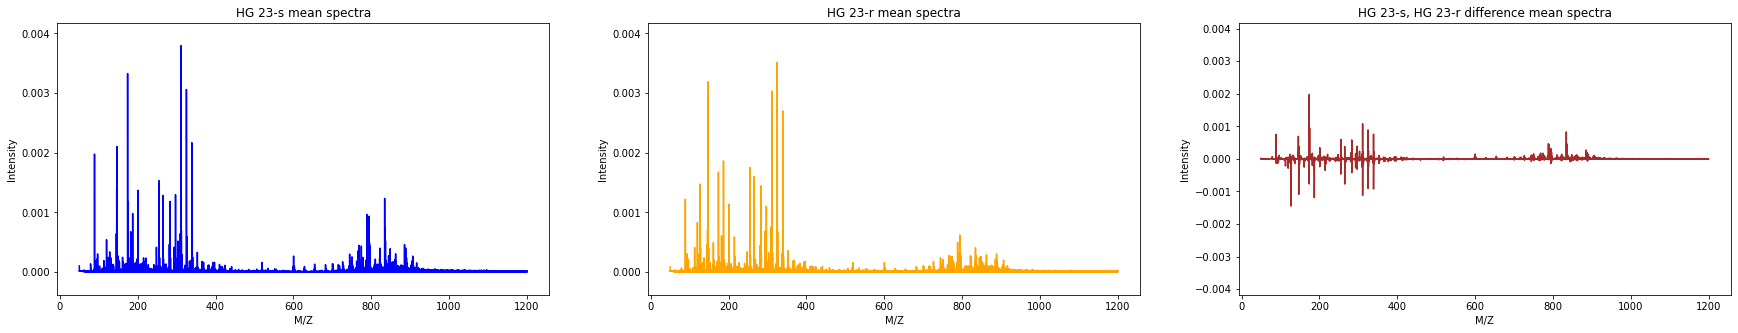

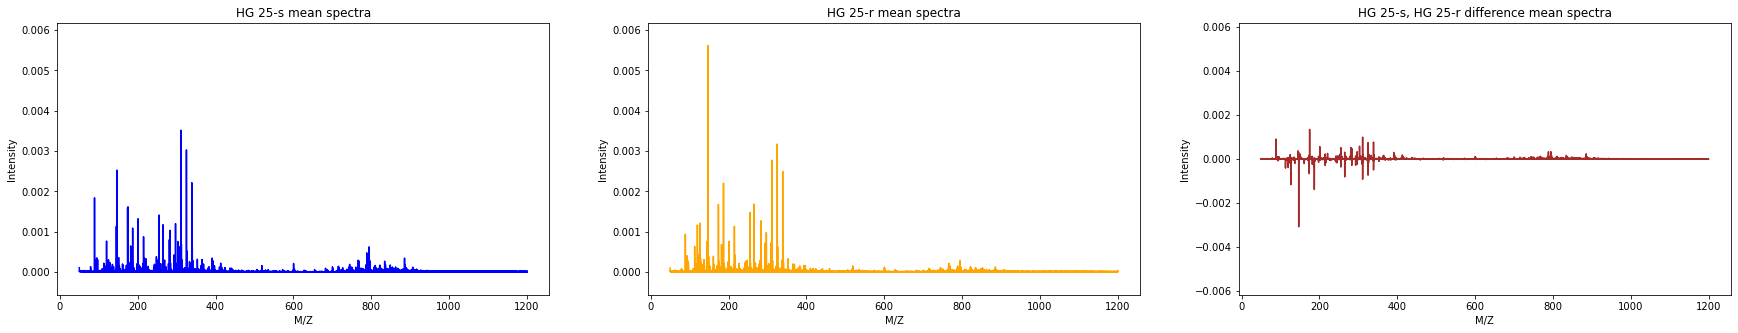

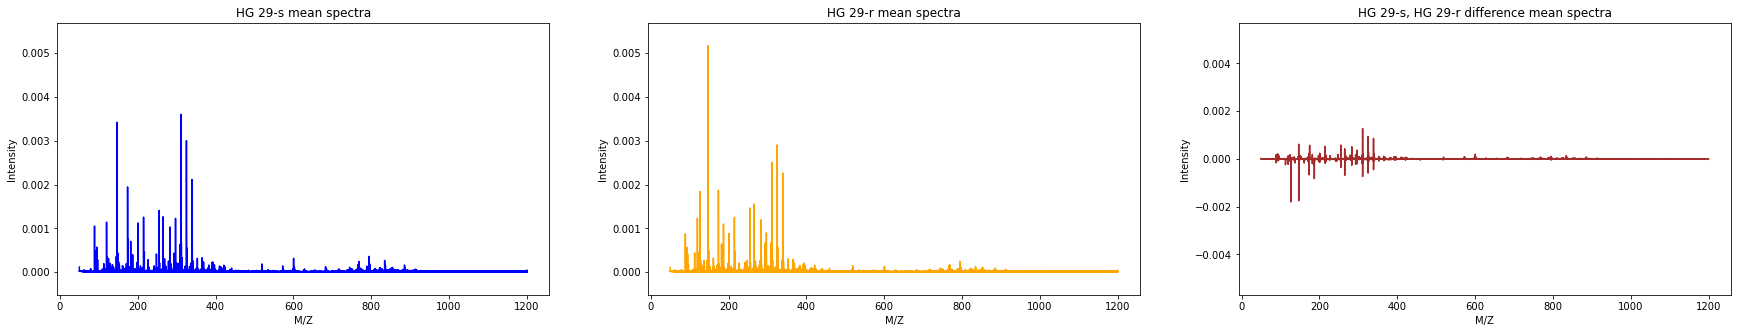

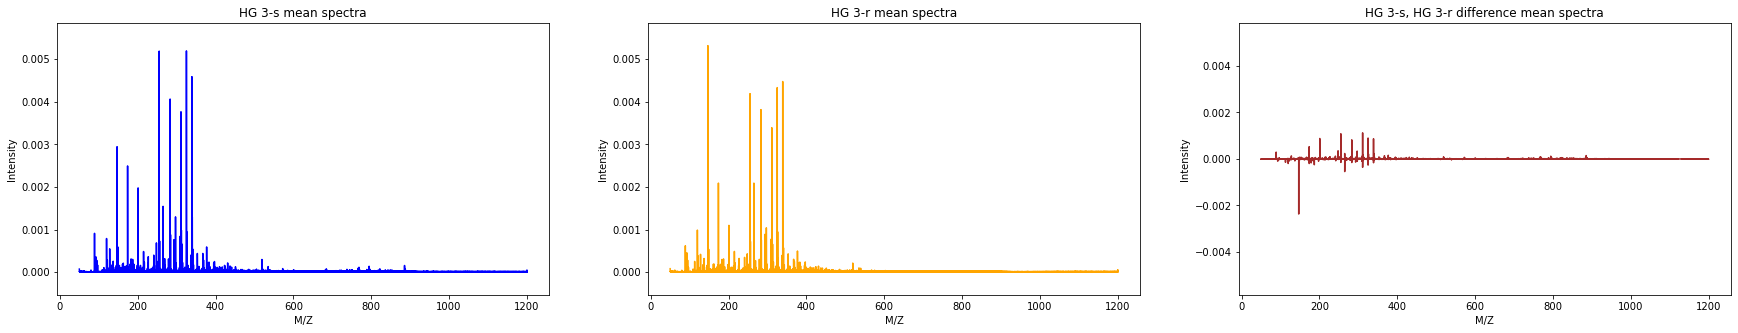

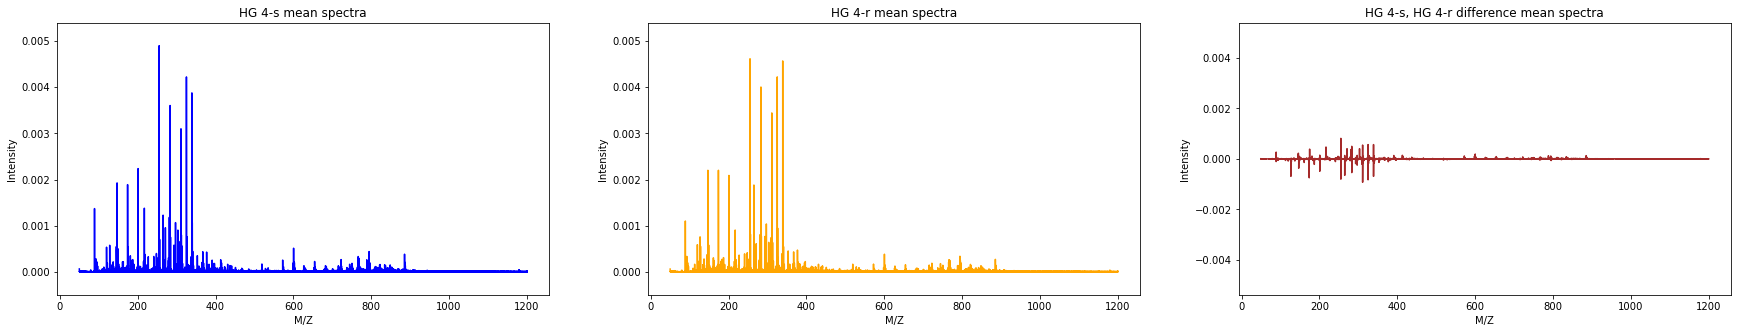

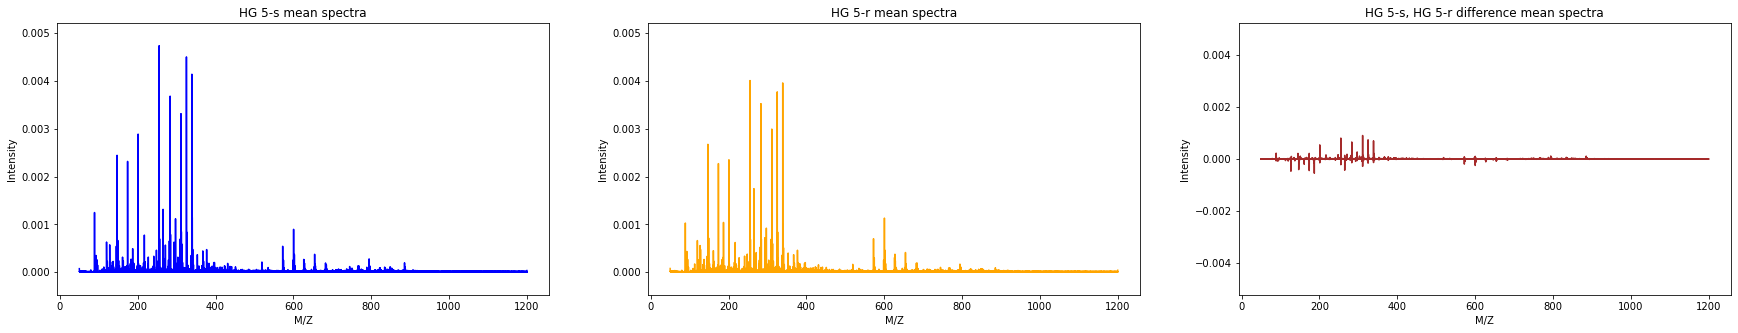

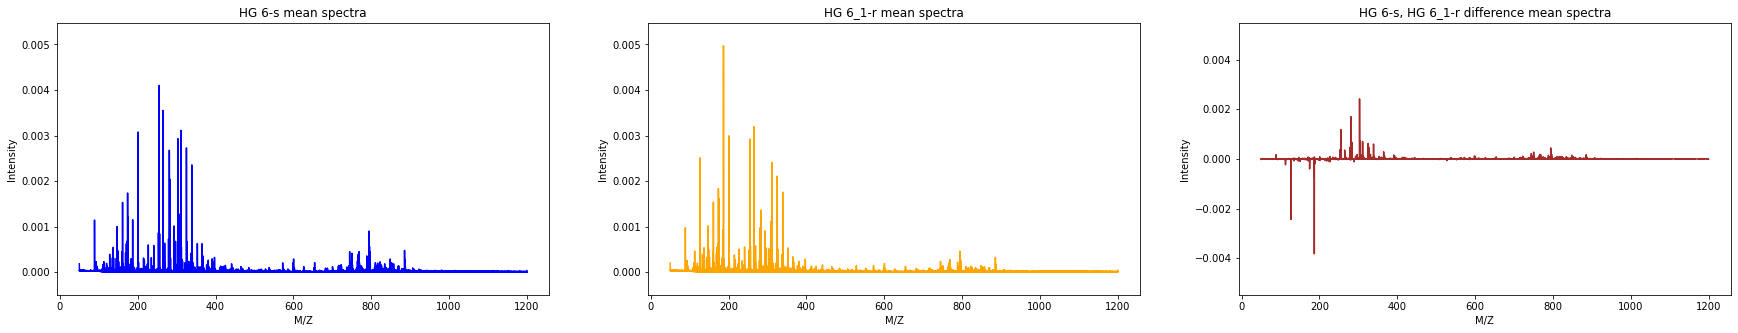

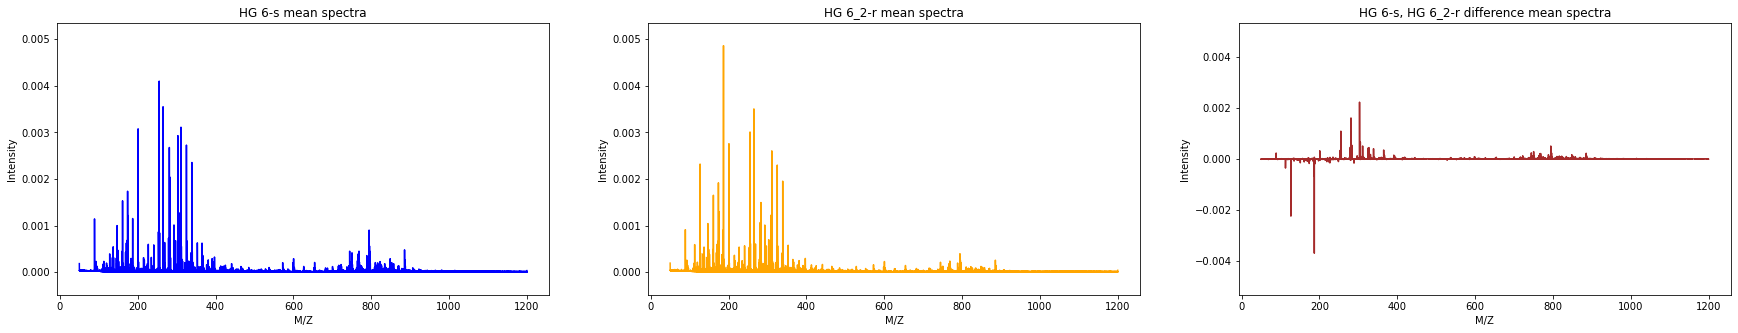

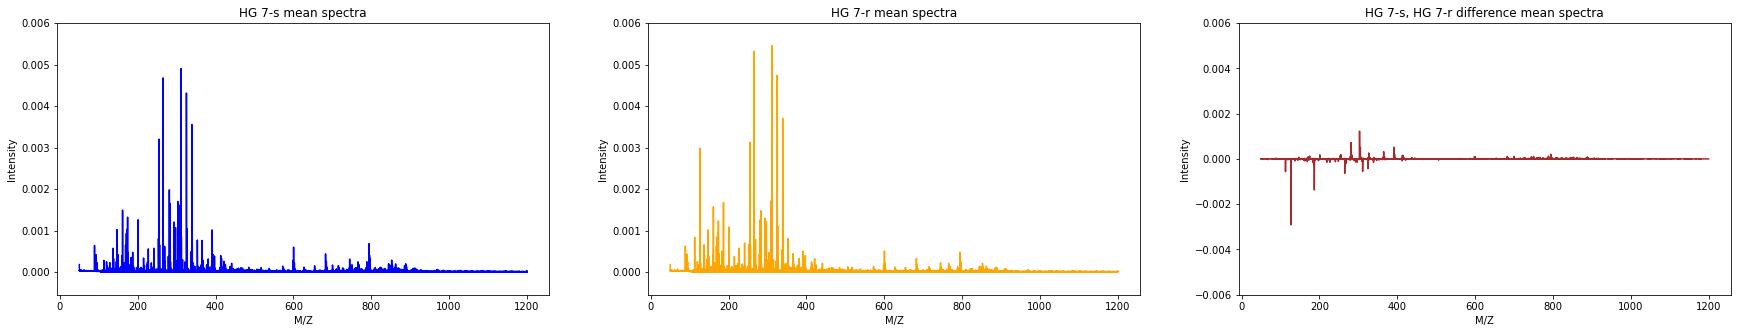

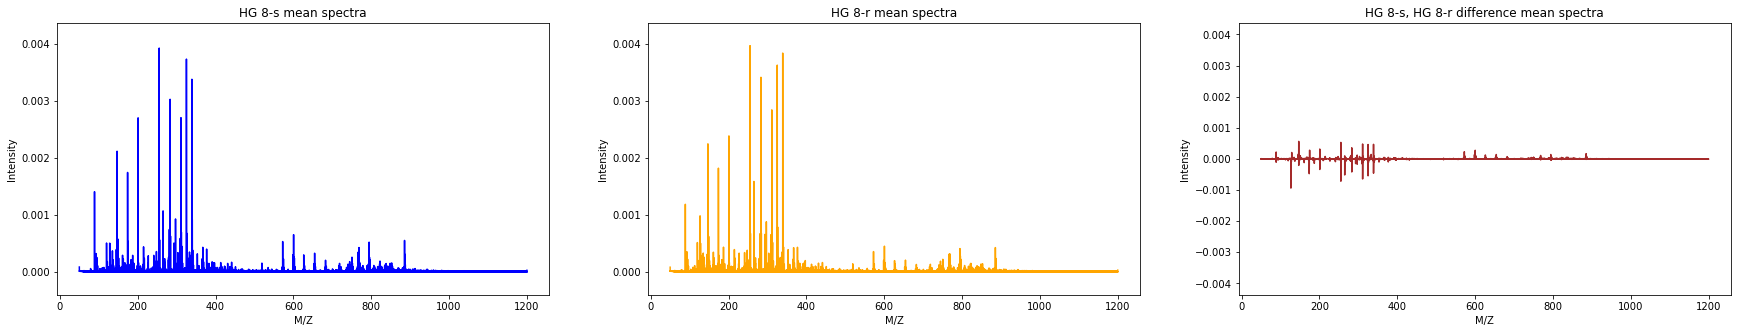

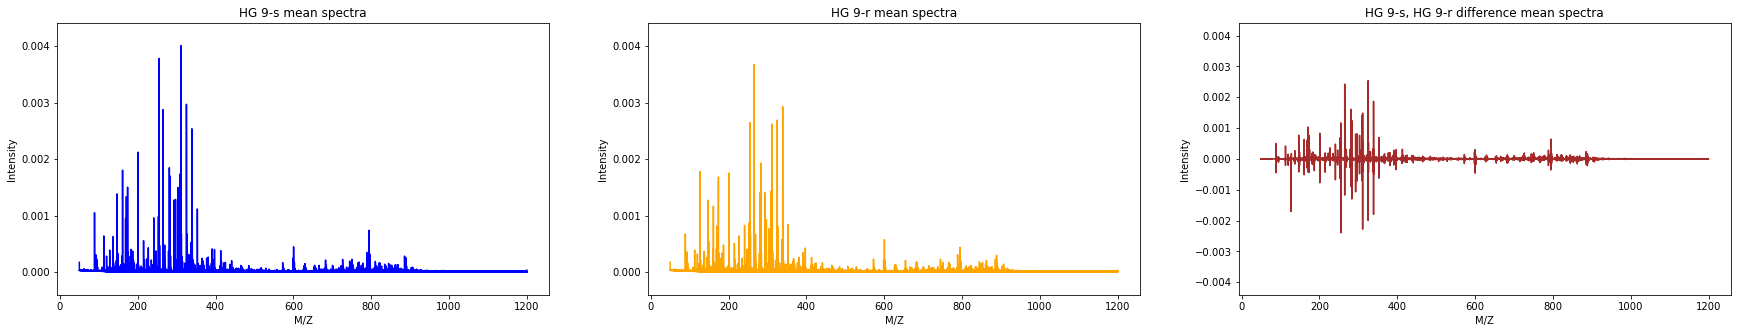

In [6]:
# Loop over each MSI
for msi_1, msi_1_mean in mean_spectras.items():
  # Check if MSI is section type and not replica
  # in order to not plot twice
  if "s" in msi_1:
    # Get MSI sample number
    msi_1_num = clinical_state_df.loc[msi_1].sample_number
    # Loop over each MSI
    for msi_2, msi_2_mean in mean_spectras.items():
      # Get MSI sample number
      msi_2_num = clinical_state_df.loc[msi_2].sample_number
      # Check if both MSI are the same sample (a replica, section pair)
      if msi_1_num == msi_2_num and msi_1 != msi_2 and 's' not in msi_2:
        # Create subplot
        fig, axes = plt.subplots(1, 3, figsize=(30, 5))
        # Get maximum intensity in order to make plot y range the same
        max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
        # Create margin for y axis in plot
        margin = 0.1 * max_y
        # Plot section msi mean spectrum
        axes[0].plot(mzs, msi_1_mean, color="Blue")
        axes[0].set_title(f"{msi_1} mean spectra")
        axes[0].set_xlabel("M/Z")
        axes[0].set_ylabel("Intensity")
        axes[0].set_ylim([-margin, max_y + margin])
        # Plot replica msi mean spectrum
        axes[1].plot(mzs, msi_2_mean, color="Orange")
        axes[1].set_title(f"{msi_2} mean spectra")
        axes[1].set_xlabel("M/Z")
        axes[1].set_ylabel("Intensity")
        axes[1].set_ylim([-margin, max_y + margin])
        # Plot section & replica msi mean spectrum difference
        axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
        axes[2].set_title(f"{msi_1}, {msi_2} difference mean spectra")
        axes[2].set_xlabel("M/Z")
        axes[2].set_ylabel("Intensity")
        axes[2].set_ylim([- (max_y + margin), max_y + margin])
        # Display plot
        plt.show()

In [7]:
# Define object to store high degree tissue spectra's sum and count
sum_spectra_high = 0
count_spectra_high = 0
# Define object to store low degree tissue spectra's sum and count
sum_spectra_low = 0
count_spectra_low = 0
# Define object to store common mz values
mzs = None

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH, f"{index}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        # Get mzs ans spectra
        mzs, intensities = reader.getspectrum(idx)
        # Check if high or low degree
        if msi_row.who_grade > 2:
          # Add spectra's
          sum_spectra_high += intensities
          count_spectra_high += 1
        else:
          # Add spectra's
          sum_spectra_low += intensities
          count_spectra_low += 1

MSI Loop: 100%|██████████| 48/48 [05:05<00:00,  6.37s/it]


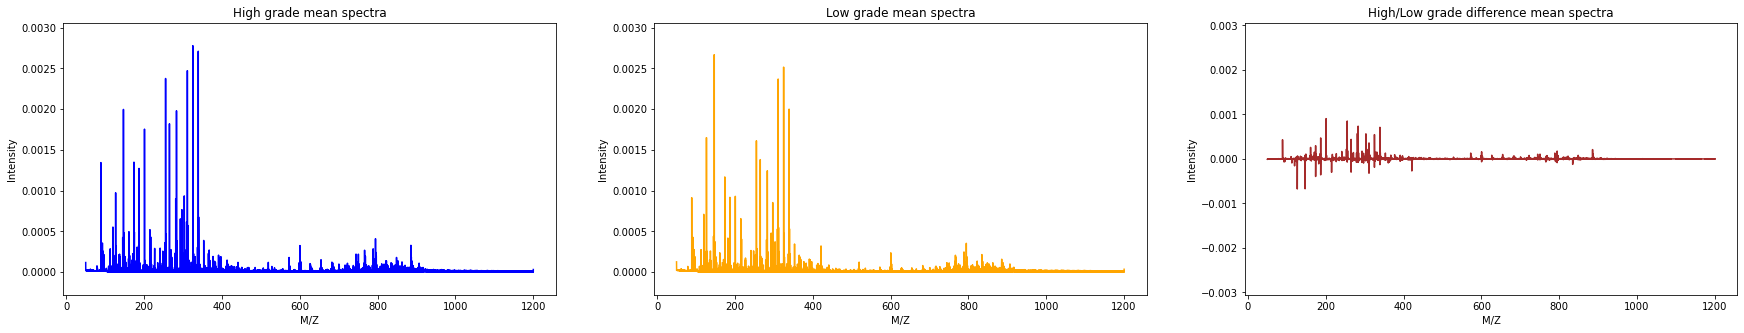

In [10]:
msi_1_mean = sum_spectra_high / count_spectra_high
msi_2_mean = sum_spectra_low / count_spectra_low

# Create subplot
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
# Get maximum intensity in order to make plot y range the same
max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
# Create margin for y axis in plot
margin = 0.1 * max_y
# Plot section msi mean spectrum
axes[0].plot(mzs, msi_1_mean, color="Blue")
axes[0].set_title("High grade mean spectra")
axes[0].set_xlabel("M/Z")
axes[0].set_ylabel("Intensity")
axes[0].set_ylim([-margin, max_y + margin])
# Plot replica msi mean spectrum
axes[1].plot(mzs, msi_2_mean, color="Orange")
axes[1].set_title(f"Low grade mean spectra")
axes[1].set_xlabel("M/Z")
axes[1].set_ylabel("Intensity")
axes[1].set_ylim([-margin, max_y + margin])
# Plot section & replica msi mean spectrum difference
axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
axes[2].set_title(f"High/Low grade difference mean spectra")
axes[2].set_xlabel("M/Z")
axes[2].set_ylabel("Intensity")
axes[2].set_ylim([- (max_y + margin), max_y + margin])
# Display plot
plt.show()

In [11]:
# Define object to store high degree tissue spectra's sum and count
sum_spectra_tissue = 0
count_spectra_tissue = 0
# Define object to store low degree tissue spectra's sum and count
sum_spectra_non_tissue = 0
count_spectra_non_tissue = 0
# Define object to store common mz values
mzs = None

# Loop over each MSI
for index, msi_row in tqdm(clinical_state_df.iterrows(),
                           total=clinical_state_df.shape[0],
                           desc="MSI Loop"):
  # Parse the MSI file
  with ImzMLParser(os.path.join(DHG_IN_PATH, f"{index}.imzML")) as reader:
    # Get local TIC image of msi in mz region [600, 900]
    local_tic_img = getionimage(reader, TRESH_MZ, tol=TRESH_MZ_TOL)

    # Threshold image to separate tissue spectra from background
    smooth = filters.gaussian(local_tic_img, sigma=TRESH_GAUSSIAN_SIGMA)
    thresh_mean = filters.threshold_mean(smooth)
    thresh_img = local_tic_img > thresh_mean

    # Loop over each spectra
    for idx, (x, y, z) in tqdm(enumerate(reader.coordinates),
                               total=len(reader.coordinates),
                               desc="Spectra Loop"):
      # Get mzs ans spectra
      mzs, intensities = reader.getspectrum(idx)
      # Check if spectra is tissue
      if thresh_img[y - 1, x - 1]:
        sum_spectra_tissue += intensities
        count_spectra_tissue += 1
      else:
        sum_spectra_non_tissue += intensities
        count_spectra_non_tissue += 1

MSI Loop: 100%|██████████| 48/48 [05:36<00:00,  7.00s/it]


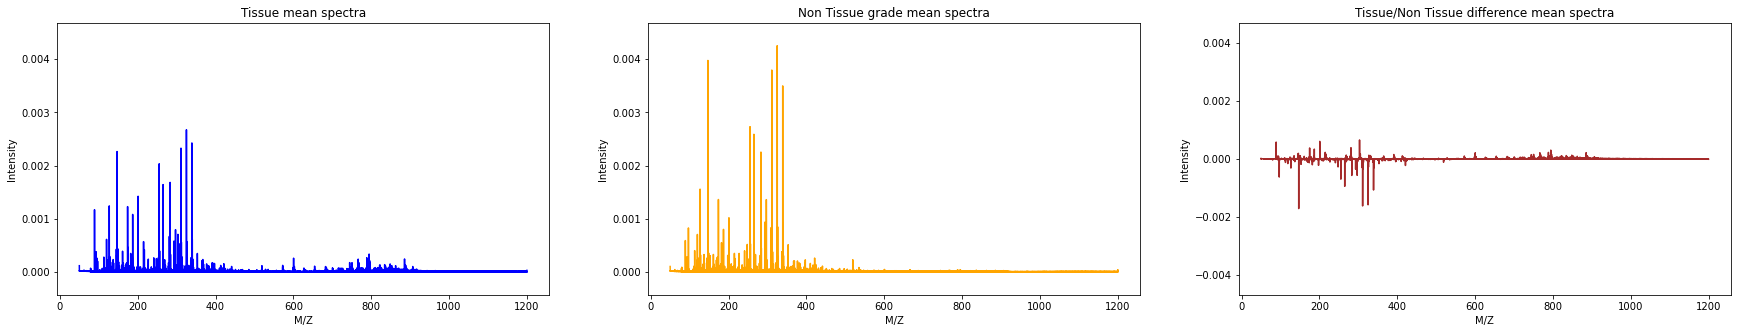

In [13]:
msi_1_mean = sum_spectra_tissue / count_spectra_tissue
msi_2_mean = sum_spectra_non_tissue / count_spectra_non_tissue

# Create subplot
fig, axes = plt.subplots(1, 3, figsize=(30, 5))
# Get maximum intensity in order to make plot y range the same
max_y = np.maximum(np.max(msi_1_mean), np.max(msi_2_mean))
# Create margin for y axis in plot
margin = 0.1 * max_y
# Plot section msi mean spectrum
axes[0].plot(mzs, msi_1_mean, color="Blue")
axes[0].set_title("Tissue mean spectra")
axes[0].set_xlabel("M/Z")
axes[0].set_ylabel("Intensity")
axes[0].set_ylim([-margin, max_y + margin])
# Plot replica msi mean spectrum
axes[1].plot(mzs, msi_2_mean, color="Orange")
axes[1].set_title(f"Non Tissue mean spectra")
axes[1].set_xlabel("M/Z")
axes[1].set_ylabel("Intensity")
axes[1].set_ylim([-margin, max_y + margin])
# Plot section & replica msi mean spectrum difference
axes[2].plot(mzs, msi_1_mean - msi_2_mean, color="Brown")
axes[2].set_title(f"Tissue/Non Tissue difference mean spectra")
axes[2].set_xlabel("M/Z")
axes[2].set_ylabel("Intensity")
axes[2].set_ylim([- (max_y + margin), max_y + margin])
# Display plot
plt.show()